In [1]:
from numba import autojit, prange

@autojit
def dense_render(K, verts, faces, shape=(480,640)):
    result = np.zeros((shape[0], shape[1], 5))
    verts_sensor = K@verts.T
    verts_sensor = verts_sensor[:-1, :]/verts_sensor[-1:, :]
    verts_sensor = verts_sensor.T
    for v in prange(faces.shape[0]):
        min_i = max(int(np.floor(verts_sensor[faces[v],0].min())), 0)
        min_j = max(int(np.floor(verts_sensor[faces[v],1].min())), 0)
        max_i = min(int(np.ceil(verts_sensor[faces[v],0].max())), result.shape[0]-1)
        max_j = min(int(np.ceil(verts_sensor[faces[v],1].max())), result.shape[1]-1)
        for i in prange(min_i, max_i+1):
            for j in prange(min_j, max_j+1):
                a = verts_sensor[faces[v,0],0] - i
                b = verts_sensor[faces[v,1],0] - verts_sensor[faces[v,0],0]
                c = verts_sensor[faces[v,2],0] - verts_sensor[faces[v,0],0]
                d = verts_sensor[faces[v,0],1] - j
                e = verts_sensor[faces[v,1],1] - verts_sensor[faces[v,0],1]
                f = verts_sensor[faces[v,2],1] - verts_sensor[faces[v,0],1]
                s = (a*f-c*d)/(c*e-b*f)
                t = (b*d-a*e)/(c*e-b*f)
                if s>=0 and s<=1 and t>=0 and t<=1 and s+t<=1:
                    vet = s*verts[faces[v,1], :]+t*verts[faces[v,2], :]+(1-s-t)*verts[faces[v,0], :]
                    if result[i,j,0]==0 or vet[2]<result[i,j,0]:
                        result[i,j,:] = [vet[2],1-s-t,s,t,v]
    return result

In [2]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np

from pycuda.compiler import SourceModule
mod = SourceModule("""
#include <stdlib.h>
#include <math.h>

__global__ void dense_render_gpu(float *result, float *verts_sensor, int *faces, int n_rows, int n_cols, int N)
{
    const int v = threadIdx.x + blockIdx.x * blockDim.x;
    if(v>=N)
        return;
    int min_i = max((int)min(min(verts_sensor[faces[v*3]*3], verts_sensor[faces[v*3+1]*3]), verts_sensor[faces[v*3+2]*3]), 0);
    int min_j = max((int)min(min(verts_sensor[faces[v*3]*3+1], verts_sensor[faces[v*3+1]*3+1]), verts_sensor[faces[v*3+2]*3+1]), 0);
    int max_i = min((int)ceil(max(max(verts_sensor[faces[v*3]*3], verts_sensor[faces[v*3+1]*3]), verts_sensor[faces[v*3+2]*3])), n_rows-1);
    int max_j = min((int)ceil(max(max(verts_sensor[faces[v*3]*3+1], verts_sensor[faces[v*3+1]*3+1]), verts_sensor[faces[v*3+2]*3+1])), n_cols-1);
    for(int i=min_i; i<=max_i; ++i)
    {
        for(int j=min_j; j<=max_j; ++j)
        {
            float a = verts_sensor[faces[v*3]*3] - i;
            float b = verts_sensor[faces[v*3+1]*3] - verts_sensor[faces[v*3]*3];
            float c = verts_sensor[faces[v*3+2]*3] - verts_sensor[faces[v*3]*3];
            float d = verts_sensor[faces[v*3]*3+1] - j;
            float e = verts_sensor[faces[v*3+1]*3+1] - verts_sensor[faces[v*3]*3+1];
            float f = verts_sensor[faces[v*3+2]*3+1] - verts_sensor[faces[v*3]*3+1];
            float s = (a*f-c*d)/(c*e-b*f);
            float t = (b*d-a*e)/(c*e-b*f);
            if(s>=0 && s<=1 && t>=0 && t<=1 && s+t<=1)
            {
                float depth = s*verts_sensor[faces[v*3+1]*3+2]+t*verts_sensor[faces[v*3+2]*3+2]+(1-s-t)*verts_sensor[faces[v*3]*3+2];
                if(result[i*n_cols*5+j*5]==0 || depth<result[i*n_cols*5+j*5])
                {
                    result[i*n_cols*5+j*5] = depth;
                    result[i*n_cols*5+j*5+1] = 1-s-t;
                    result[i*n_cols*5+j*5+2] = s;
                    result[i*n_cols*5+j*5+3] = t;
                    result[i*n_cols*5+j*5+4] = v;
                }
            }
        
        }
    }
}
""")

dense_render_gpu_helper = mod.get_function("dense_render_gpu")
def dense_render_gpu(K, verts, faces, shape=(480,640)):
    N = faces.shape[0]

    nThreads = 1024
    nBlocks = (N+nThreads-1)//nThreads

    n_rows, n_cols = shape
    result = np.zeros((n_rows, n_cols, 5), dtype=np.float32)

    verts_sensor = K@verts.T
    verts_sensor = verts_sensor[:-1, :]/verts_sensor[-1:, :]
    verts_sensor = np.ascontiguousarray(np.hstack([verts_sensor.T, verts[:, -1:]]), np.float32)
    faces_cont = np.ascontiguousarray(faces)

    start = time()
    dense_render_gpu_helper(
            drv.Out(result), drv.In(verts_sensor), drv.In(faces_cont), np.int32(n_rows), np.int32(n_cols), np.int32(N),
            block=(nThreads,1,1), grid=(nBlocks,1))
    return result

In [3]:
def interpolation_helper(render_result, verts, normals, faces):
    result = np.zeros((render_result.shape[0], render_result.shape[1], 6))
    interp_coef = render_result[:,:,1:4][...,np.newaxis,:]
    v = render_result[:,:,4].astype(np.int)
    result[:,:,0:3] = (interp_coef@verts[faces[v]])[...,0,:]
    result[:,:,3:6] = (interp_coef@normals[faces[v]])[...,0,:]
    return result

In [4]:
# from time import time
# start = time()
# render_result_gpu = dense_render_gpu(K, verts, faces)
# I_gpu = interpolation_helper(render_result_gpu, verts, normals, faces)
# print("GPU Took: {:.3f}s".format(time()-start))

# start = time()
# render_result = dense_render(K, verts, faces)
# I = interpolation_helper(render_result, verts, normals, faces)
# print("CPU Took: {:.3f}s".format(time()-start))

# plt.figure(figsize=(14,8))
# plt.subplot(2,2,1)
# plt.imshow(render_result_gpu[:,:,0], vmin=0.7, vmax=2)
# plt.colorbar()
# plt.title("Densely Rendered by GPU")
# plt.subplot(2,2,2)
# plt.imshow(I_gpu[:,:,2], vmin=0.7, vmax=2)
# plt.colorbar()
# plt.title("Interpolated")
# plt.subplot(2,2,3)
# plt.imshow(render_result[:,:,0], vmin=0.7, vmax=2)
# plt.colorbar()
# plt.title("Densely Rendered by CPU")
# plt.subplot(2,2,4)
# plt.imshow(I[:,:,2], vmin=0.7, vmax=2)
# plt.colorbar()
# plt.title("Interpolated")
# plt.show()

## Necessary Libraries

In [5]:
from PIL import Image
import numpy as np
import numpy.linalg as LA
from numpy.linalg import norm
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
%matplotlib inline
%load_ext line_profiler

## Defining function to update TSDF

In [6]:
from TSDF import update_TSDF

## Update TSDF

In [7]:
def load_depth(n):
    img = np.array(Image.open('../data/umbrella/frame-{:0>6}.depth.png'.format(n)))/1000
    return img*(img<1.4)

In [8]:
from time import time
start = time()
x_range = (-1,1)
y_range = (-1,1)
z_range = (0.7,3)
N = 128
t_range = [0,150]
t = t_range[0]
tau = (z_range[1]-z_range[0])/N*3
TSDF_v = np.ones((N,N,N))*0.01
TSDF_w = np.zeros((N,N,N))
idces = np.stack(np.meshgrid(np.arange(TSDF_v.shape[0]), np.arange(TSDF_v.shape[1]), np.arange(TSDF_v.shape[2])), 3).reshape([-1,3]).T
dc_idces = (idces/np.array(TSDF_v.shape)[:,None]*\
    np.array([[x_range[1]-x_range[0]],[y_range[1]-y_range[0]],[z_range[1]-z_range[0]]])+\
    np.array([[x_range[0]],[y_range[0]],[z_range[0]]])).T[...,None]
K = np.array([[570.342, 0, 320], [0, 570.342, 240], [0, 0, 1]])
Kinv = np.linalg.inv(K)
Dt = load_depth(t)
rMat = np.repeat(np.eye(3)[None,...], dc_idces.shape[0], 0)
tvec = np.zeros((dc_idces.shape[0], 3,1))
ckp1 = time()
update_TSDF(rMat, tvec, Dt, K, TSDF_v, TSDF_w, tau, idces, dc_idces)
ckp2 = time()
verts, faces, normals, values = measure.marching_cubes_lewiner(TSDF_v, 0)
verts[:,0] = verts[:,0]/N*(x_range[1]-x_range[0])+x_range[0]
verts[:,1] = verts[:,1]/N*(y_range[1]-y_range[0])+y_range[0]
verts[:,2] = verts[:,2]/N*(z_range[1]-z_range[0])+z_range[0]
end = time()
print("Data Prep: {:.3f}s, Calculating TSDF: {:.3f}s, Marching Cube: {:.3f}s, Total: {:.3f}s".format(ckp1-start, ckp2-ckp1, end-ckp2, end-start))


Data Prep: 0.235s, Calculating TSDF: 2.065s, Marching Cube: 0.038s, Total: 2.338s


## Writing to OBJ file

In [9]:
def write_to_obj(verts, normals, faces, filename="object.obj"):
    with open(filename, "wt") as f:
        f.write("# OBJ file created by some python code\n")
        f.write("#\n")
        f.write("g Obj{}\n".format(N))
        f.write("\n")
        for v in verts:
            f.write("v  {:.4f}  {:.4f}  {:.4f}\n".format(v[0], v[1], v[2]))
        f.write("\n")
        for n in normals:
            f.write("n  {:.4f}  {:.4f}  {:.4f}\n".format(n[0], n[1], n[2]))
        f.write("\n")
        for face in faces:
            f.write("f  {}  {}  {}\n".format(face[0]+1, face[1]+1, face[2]+1))
# write_to_obj(verts, normals, faces)

In [ ]:
import numpy as np
A@B
np,matmul(A, B)


In [2]:
A = np.arange(9).reshape(3,3)

In [5]:
A[1,:]

array([3, 4, 5])

In [16]:
t = None
class A:
    def __init__(self):
        A = [1,2,3,4]
    
    def __getitem__(self, idx):
        global t
        t = idx
        print(idx)

In [24]:
a = A()
a[1:2:3, ..., 2]

(slice(1, 2, 3), Ellipsis, 2)


In [25]:
slice(1,2,3)

slice(1, 2, 3)

# Nodes

In [10]:
@autojit
def calcDataJacobian(verts, normals, dg_v, dg_w, dg_se3, vl_u, mask_sensor, verts_neighbor):
    
    nVerts = verts.shape[0]
    nNodes = dg_v.shape[0]
    nNeighbors = verts_neighbor.shape[1]
    
    error_data = np.zeros(nVerts)
    pixels = np.zeros((nVerts, 2), dtype=np.int)
    jacobian = np.zeros((nVerts, 6*nNodes))
    gradient = np.zeros(6*nNodes)
    hessian_blocks = np.zeros((6*nNodes, 6))
    
    
    start_time=time()
    proj_count = 0
    
    weights = np.exp(-np.sum((dg_v[verts_neighbor]-verts[:,None,:])**2, axis=2) / (2*dg_w[verts_neighbor]**2))
    #     Dual quaternion of each neighboring node
    dq = se32dq(dg_se3[verts_neighbor])
    #     Blending
    DQB = (weights[:,None,:]@dq)[:,0,:]
    #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
    norm_DQB = np.linalg.norm(DQB[:, :4], axis=1, keepdims=True)
    DQB = DQB / norm_DQB
    rMat, tvec = dq2SE3(DQB)
    #     Warping, note that normal does not depend on t
    verts_warped = (rMat @ verts[...,None])[...,0] + tvec
    normals_warped = (rMat @ normals[...,None])[...,0] # No translation
    #     Pixels data association
    pixels, mask = render(verts_warped, K)
#     pixels = np.round(fromHomo(K @ verts_warped.T).T).astype(np.int)
#     mask = np.all([np.all(pixels>0, axis=1), pixels[:, 0]<480, pixels[:,1]<640], axis=0)
    mask_t = mask_sensor[pixels[mask, 0], pixels[mask, 1]]
    mask[mask] = mask_t
    proj_count = mask.sum()
    #     Energy term
    error_data[mask] = np.matmul(normals_warped[mask,None,...], (verts_warped[mask,...,None] - vl_u[pixels[mask,0],pixels[mask,1]][...,None]))[:,0,0]
    
    for i in prange(nVerts):
    #     if mask[i] == False:
    #         continue

        neighbors = verts_neighbor[i]
        if mask[i]==False:
            continue

        #     As the names suggest
        dv_ddq = np.hstack((drotated_dq0(verts[i], DQB[i,:4]), np.zeros((3,4)))) + dt_ddq(DQB[i,:])  
        dn_ddq = np.hstack((drotated_dq0(normals[i], DQB[i,:4]), np.zeros((3,4)))) # No translation
        #     d_Energy / d_DQB
        block1 = error_data[i] * ((verts_warped[i,:] - vl_u[pixels[i,0],pixels[i,1]]) @ dn_ddq + normals_warped[i,:] @ dv_ddq)
        #     Jacobian of DQB WRT each dual quaternion

        for j in range(nNeighbors):
    #         d_DQB / d_dq
            block2 = weights[i,j] * (np.identity(8) / norm_DQB[i,0] - \
            DQB[i,:].reshape(-1,1) @ np.hstack([DQB[i, :4], [0.,0.,0.,0.]]).reshape(1,-1) / norm_DQB[i,0])
    #         Transform back to se3 to calculate d_dq / d_se3
            se3 = dg_se3[neighbors[j]]
    #         Previously se3 = dq2se3(dq[j])
    #         d_dq / d_se3
            block3 = np.hstack((ddq_dw(se3[:3], se3[3:]), np.vstack([np.zeros((4, 3)), dqe_dt(se3[:3])])))
    #         Final Jacobian
            jacobian[i, 6*neighbors[j]:6*neighbors[j]+6] = block1 @ block2 @ block3
    #         Gradient
            gradient[6*neighbors[j]:6*neighbors[j]+6] += \
            error_data[i] * jacobian[i, 6*neighbors[j]:6*neighbors[j]+6]
    #         Diagonal Hessian blocks
            hessian_blocks[6*neighbors[j]:6*neighbors[j]+6] += \
            jacobian[i, 6*neighbors[j]:6*neighbors[j]+6].reshape(-1,1)\
            @ jacobian[i, 6*neighbors[j]:6*neighbors[j]+6].reshape(1,-1)
    cost_mean = (error_data**2).sum() / (2*proj_count)
    print("Mean cost: ", cost_mean)
#     print("Points projected on image planes: ", proj_count, '/', nVerts)
#     print("--- %s seconds ---" % (time() - start_time))
    
    return error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient

In [11]:
@autojit
def updateAll(verts, normals, dg_se3, vl_u, mask_sensor, weights, verts_neighbor,\
              hessian_blocks, gradient, steplength):
    
    nVerts = verts.shape[0]
    
    dg_se3_new = dg_se3.copy()
    start_time=time()
    proj_count = 0
    #     print(steplength)
    dg_se3_new += steplength * gradient.reshape([-1,6])
    
    error_data = np.zeros(nVerts)
    #     Dual quaternion of each neighboring node
    dq = se32dq(dg_se3_new[verts_neighbor])
    #     Blending
    DQB = (weights[:,None,:]@dq)[:,0,:]
    #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
    norm_DQB = np.linalg.norm(DQB[:, :4], axis=1, keepdims=True)
    DQB = DQB / norm_DQB
    rMat, tvec = dq2SE3(DQB)
    #     Warping, note that normal does not depend on t
    verts_warped = (rMat @ verts[...,None])[...,0] + tvec
    normals_warped = (rMat @ normals[...,None])[...,0] # No translation
    #     Pixels data association
    pixels = np.round(fromHomo(K @ verts_warped.T).T).astype(np.int)
    mask = np.all([np.all(pixels>0, axis=1), pixels[:, 0]<480, pixels[:,1]<640], axis=0)
    mask_t = mask_sensor[pixels[mask, 0], pixels[mask, 1]]
    mask[mask] = mask_t
    proj_count = mask.sum()
    #     Energy terme planes: ", proj_count, '/', nVerts)
#     print("--- %s seconds ---" % (time() - start_time))
    error_data[mask] = np.matmul(normals_warped[mask,None,...], (verts_warped[mask,...,None] - vl_u[pixels[mask,0],pixels[mask,1]][...,None]))[:,0,0]
    
    cost_mean = (error_data**2).sum() / (2*proj_count)
#     print("Updated mean cost: ", cost_mean) 
#     print("Points projected on image planes: ", proj_count, '/', nVerts)
#     print("--- %s seconds ---" % (time() - start_time))
    
    return dg_se3_new

C:\Users\marti\Miniconda3\lib\site-packages\scipy\spatial\kdtree.py:74: RuntimeWarning: invalid value encountered in sqrt
  return minkowski_distance_p(x, y, p)**(1./p)


13.379999160766602


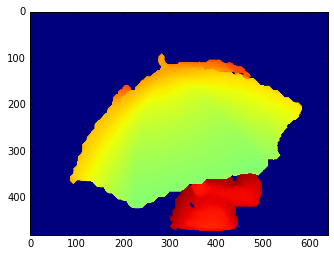

Mean cost:  0.0106745171171


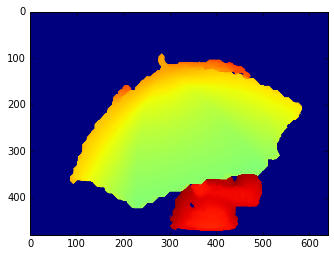

Mean cost:  0.0105248970376


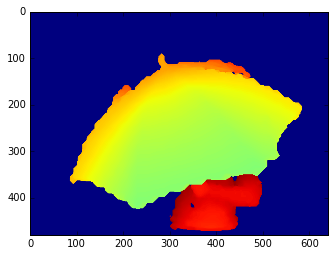

Mean cost:  0.0102473474833


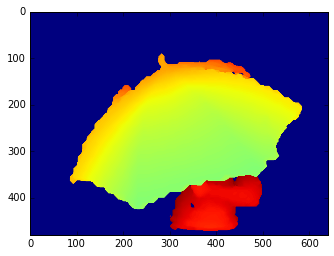

Mean cost:  0.00976970098275


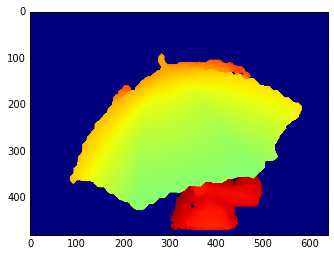

Mean cost:  0.00896214510914


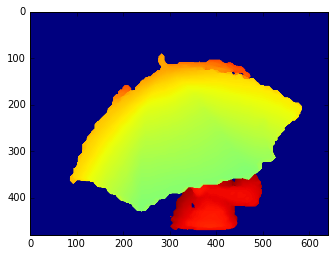

Mean cost:  0.00769789891704


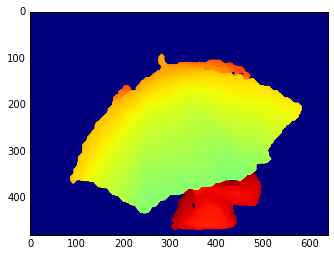

Mean cost:  0.006186603373


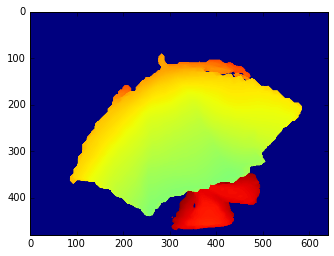

Mean cost:  0.00524934871958


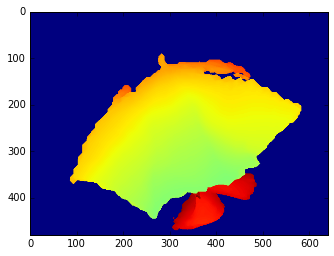

Mean cost:  0.00402815312488


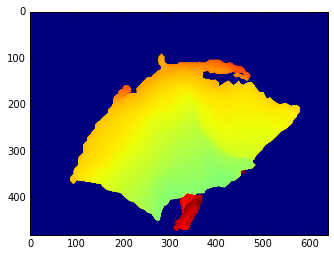

Mean cost:  0.00137452429684
621.427531003952


C:\Users\marti\Miniconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\marti\Miniconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


630.9465317726135


NameError: name 'GPU' is not defined

In [12]:
from time import time
from OptUtils import *
from WarpField import *
def calc3DMap(depthmap,K):
    K_inv = LA.inv(K)
    mask = depthmap!=0
    m, n = depthmap.shape[:2]
    X,Y = np.meshgrid(np.arange(depthmap.shape[0]), np.arange(depthmap.shape[1]))
    world_pts = (K_inv@np.vstack([X.flatten(), Y.flatten(), np.ones((X.size))])) * depthmap.T.flatten()[None, ...]
    world_pts = world_pts.reshape((3, n, m)).transpose([2,1,0])

    return world_pts, mask

eps = 0.1 #meters
nNeighbors = 8
nVerts = verts.shape[0]
nNodes = 100
# raise ValueError("Haha")
start = time()
node_idces = getNodes(verts, eps, nNodes)
dg_v = verts[node_idces, :]
dg_w = k_nearest(dg_v, dg_v, nNeighbors)[1].min(axis=1)/2
dg_se3 = np.zeros((node_idces.shape[0], 6))
nNodes = dg_v.shape[0]
verts_neighbor, verts_neighbor_dist = k_nearest(verts,dg_v,8)
dc_idces_neighbor, dc_idces_neighbor_dist = k_nearest(dc_idces[...,0], dg_v, nNeighbors)
weights_dc_idces = np.exp(-np.sum((dc_idces[...,0][dc_idces_neighbor]-dc_idces[...,0][:,None,:])**2, axis=2) / (2*dg_w[dc_idces_neighbor]**2))
print(time()-start)
    
write_to_obj(verts, normals, faces, "Objects/C{:0>6}.obj".format(t))
for t in t_range[1:]:
    start = time()
    
    depthmap = load_depth(t)
    vl_u, mask_sensor = calc3DMap(depthmap, K)

    dg_se3_test = dg_se3.copy()
    max_iter = 10
    last_error = np.inf
    last_status = None
    step_length = 1e-5
    for n_iter in range(max_iter):
    #     if n_iter>=0.5*max_iter:
    #         step_length *= 0.3
        weights = np.exp(-np.sum((dg_v[verts_neighbor]-verts[:,None,:])**2, axis=2) / (2*dg_w[verts_neighbor]**2))
        #     Dual quaternion of each neighboring node
        dq = se32dq(dg_se3_test[verts_neighbor])
        #     Blending
        DQB = (weights[:,None,:]@dq)[:,0,:]
        #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
        norm_DQB = np.linalg.norm(DQB[:, :4], axis=1, keepdims=True)
        DQB = DQB / norm_DQB
        rMat, tvec = dq2SE3(DQB)
        #     Warping, note that normal does not depend on t
        verts_warped = (rMat @ verts[...,None])[...,0] + tvec
        
        verts_dense = interpolation_helper(dense_render(K, verts_warped, faces), verts, normals, faces)
        verts_dense_mask = np.any(verts_dense, axis=-1)
        
        verts_dense_neighbor, verts_dense_neighbor_dist = k_nearest(verts_dense[verts_dense_mask][:,:3] ,dg_v, nNeighbors)
        plt.figure()
        plt.imshow(verts_dense[:,:,2])
        plt.show()
        
        error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient = \
        calcDataJacobian(verts_dense[verts_dense_mask][:,:3], verts_dense[verts_dense_mask][:,3:], dg_v, dg_w, dg_se3_test, vl_u, mask_sensor, verts_dense_neighbor)

        dg_se3_test = updateAll(verts_dense[verts_dense_mask][:,:3], verts_dense[verts_dense_mask][:,3:], dg_se3_test, vl_u, mask_sensor, weights, verts_dense_neighbor,\
                  hessian_blocks, gradient, step_length)
        if cost_mean<last_error:
            step_length *= 2
            last_status = (error_data.copy(), cost_mean, weights.copy(), pixels.copy(), jacobian.copy(), hessian_blocks.copy(), gradient.copy(), dg_se3_test.copy())
            last_error = cost_mean
        else:
            step_length /= 2
            if last_status:
                error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient, dg_se3_test = last_status
            else:
                dg_se3_test = dg_se3.copy()
    if last_status:
        error_data, cost_mean, weights, pixels, jacobian, hessian_blocks, gradient, dg_se3_test = last_status
    else:
        dg_se3_test = dg_se3.copy()
    dg_se3 = dg_se3_test
    print(time()-start)
    
    #     Dual quaternion of each neighboring node
    dq = se32dq(dg_se3[dc_idces_neighbor])
    #     Blending
    DQB = (weights_dc_idces[:,None,:]@dq)[:,0,:]
    #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
    norm_DQB = np.linalg.norm(DQB[:, :4], axis=1, keepdims=True)
    DQB = DQB / norm_DQB
    DQB[np.isnan(DQB.sum(axis=1)),:] = np.array([[1,0,0,0,0,0,0,0]])
    rMat, tvec = dq2SE3(DQB)
    print(time()-start)
    update_TSDF(rMat, tvec[...,None], depthmap, K, TSDF_v, TSDF_w, tau, idces, dc_idces, GPU=GPU)
    # Use marching cubes to obtain the surface mesh
    if GPU:
        TSDF_v_cpu = np.asnumpy(TSDF_v)
    else:
        TSDF_v_cpu = TSDF_v
    verts, faces, normals, values = measure.marching_cubes_lewiner(TSDF_v_cpu, 0)
    verts[:,0] = verts[:,0]/N*(x_range[1]-x_range[0])+x_range[0]
    verts[:,1] = verts[:,1]/N*(y_range[1]-y_range[0])+y_range[0]
    verts[:,2] = verts[:,2]/N*(z_range[1]-z_range[0])+z_range[0]
    print(time()-start)
    nVerts = verts.shape[0]
    
    verts_neighbor, verts_neighbor_dist = k_nearest(verts, dg_v, nNeighbors)
    
    write_to_obj(verts, normals, faces, "Objects/C{:0>6}.obj".format(t))
    print(time()-start)
    weights = np.exp(-np.sum((dg_v[verts_neighbor]-verts[:,None,:])**2, axis=2) / (2*dg_w[verts_neighbor]**2))
    #     Dual quaternion of each neighboring node
    dq = se32dq(dg_se3[verts_neighbor])
    #     Blending
    DQB = (weights[:,None,:]@dq)[:,0,:]
    #     Normalizing DQB, norm will be used in calculating d_DQB / d_dq
    norm_DQB = np.linalg.norm(DQB[:, :4], axis=1, keepdims=True)
    DQB = DQB / norm_DQB
    rMat, tvec = dq2SE3(DQB)
    #     Warping, note that normal does not depend on t
    verts_warped = (rMat @ verts[...,None])[...,0] + tvec
    normals_warped = (rMat @ normals[...,None])[...,0] # No translation
    write_to_obj(verts_warped, normals_warped, faces, "Objects/C{:0>6}_Warped.obj".format(t))
    print(t, time()-start)
    start = time()

In [14]:
dg_se3_test

array([[  6.85226535e-01,   8.16975210e-01,  -2.14478002e-01,
          8.01850723e-01,  -3.60419196e-01,   1.17495735e+00],
       [  1.05747627e-01,   1.39821881e-01,  -5.79251797e-02,
          1.99171881e-01,   1.38321751e-03,   3.52813912e-01],
       [  8.46367519e-02,   4.37100818e-02,  -1.25899849e-02,
          2.66305055e-02,  -4.96239489e-02,   7.24830335e-02],
       [  1.05751730e-01,   2.76225527e-01,  -6.80683718e-02,
          2.91109735e-01,   1.27948901e-01,   9.58616691e-01],
       [ -4.46239319e-01,   6.49295720e-01,  -6.28955913e-02,
          7.38772305e-01,   5.77888107e-01,   7.16030565e-01],
       [ -1.03870596e-01,  -1.43164879e-02,   2.63536786e-02,
          2.97694915e-02,   1.93622877e-01,   3.58124700e-01],
       [  2.43995202e-01,   1.72083664e-01,  -9.42106213e-02,
          2.68211982e-01,  -4.86806491e-02,   5.99056228e-01],
       [  7.18823598e-01,   8.24333441e-01,  -2.29057922e-01,
          9.61209467e-01,  -5.48820609e-01,   1.04188992e+00],
